In [1]:

# basic imports
from __future__ import print_function
import numpy as np
from numpy.linalg import eig, inv
import time

# plotting elements
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import matplotlib as mpl
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
cmap = cm.RdBu_r



# exptool imports
from exptool.io import psp_io
from exptool.utils import kde_3d
from exptool.observables import transform
from exptool.analysis import pattern
from exptool.analysis import trapping
from exptool.utils import *
from exptool.observables import visualize

# astropy imports
import astropy.coordinates as coord
import astropy.units as u

import scipy.interpolate as interpolate
from scipy.interpolate import UnivariateSpline
import scipy

# ipython reload capabilities for edits to external code
%load_ext autoreload
%autoreload 2


import reflexmotion as rm

from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp1d

from astropy.io import fits


In [2]:

#http://docs.astropy.org/en/stable/generated/examples/coordinates/plot_sgr-coordinate-frame.html

from astropy.coordinates import frame_transform_graph
from astropy.coordinates.matrix_utilities import rotation_matrix, matrix_product, matrix_transpose
import astropy.coordinates as coord
import astropy.units as u

class Sagittarius(coord.BaseCoordinateFrame):
    """
    A Heliocentric spherical coordinate system defined by the orbit
    of the Sagittarius dwarf galaxy, as described in
        http://adsabs.harvard.edu/abs/2003ApJ...599.1082M
    and further explained in
        http://www.stsci.edu/~dlaw/Sgr/.

    Parameters
    ----------
    representation : `BaseRepresentation` or None
        A representation object or None to have no data (or use the other keywords)
    Lambda : `Angle`, optional, must be keyword
        The longitude-like angle corresponding to Sagittarius' orbit.
    Beta : `Angle`, optional, must be keyword
        The latitude-like angle corresponding to Sagittarius' orbit.
    distance : `Quantity`, optional, must be keyword
        The Distance for this object along the line-of-sight.
    pm_Lambda_cosBeta : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion along the stream in ``Lambda`` (including the
        ``cos(Beta)`` factor) for this object (``pm_Beta`` must also be given).
    pm_Beta : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion in Declination for this object (``pm_ra_cosdec`` must
        also be given).
    radial_velocity : :class:`~astropy.units.Quantity`, optional, must be keyword
        The radial velocity of this object.

    """

    default_representation = coord.SphericalRepresentation
    default_differential = coord.SphericalCosLatDifferential

    frame_specific_representation_info = {
        coord.SphericalRepresentation: [
            coord.RepresentationMapping('lon', 'Lambda'),
            coord.RepresentationMapping('lat', 'Beta'),
            coord.RepresentationMapping('distance', 'distance')]
    }
    
    

SGR_PHI = (180 + 3.75) * u.degree # Euler angles (from Law & Majewski 2010)
SGR_THETA = (90 - 13.46) * u.degree
SGR_PSI = (180 + 14.111534) * u.degree


# Generate the rotation matrix using the x-convention (see Goldstein)
D = rotation_matrix(SGR_PHI, "z")
C = rotation_matrix(SGR_THETA, "x")
B = rotation_matrix(SGR_PSI, "z")
A = np.diag([1.,1.,-1.])
SGR_MATRIX = matrix_product(A, B, C, D)

@frame_transform_graph.transform(coord.StaticMatrixTransform, coord.Galactic, Sagittarius)
def galactic_to_sgr():
    """ Compute the transformation matrix from Galactic spherical to
        heliocentric Sgr coordinates.
    """
    return SGR_MATRIX

@frame_transform_graph.transform(coord.StaticMatrixTransform, Sagittarius, coord.Galactic)
def sgr_to_galactic():
    """ Compute the transformation matrix from heliocentric Sgr coordinates to
        spherical Galactic.
    """
    return matrix_transpose(SGR_MATRIX)




In [3]:
# see https://gea.esac.esa.int/archive/documentation/GDR2/Data_processing/chap_cu3ast/sec_cu3ast_intro/ssec_cu3ast_intro_tansforms.html


def return_gaia_Agprime():
    """return the matrix in eq 3.61, key to transform from ICRS to galactic coordinates"""
    return np.array([[-0.0548755604162154,-0.8734370902348850,-0.4838350155487132],
                     [+0.4941094278755837,-0.4448296299600112,+0.7469822444972189],
                     [-0.8676661490190047,-0.1980763734312015,+0.4559837761750669]])

def return_ricrs(a,d):
    """ eq. 3.57"""
    return np.array([np.cos(a)*np.cos(d),np.sin(a)*np.cos(d),np.sin(d)]).T

def return_picrs(a,d):
    """ eq. 3.64, unit vector of increasing alpha"""
    return np.array([-np.sin(a),np.cos(a),0.]).T

def return_qicrs(a,d):
    """ eq. 3.64, unit vector of increasing delta"""
    return np.array([-np.cos(a)*np.sin(d),-np.sin(a)*np.sin(d),np.cos(d)]).T

def return_muicrs(a,d,mua,mud):
    """ eq. 3.66, the proper motion vector"""
    p = return_picrs(a,d)
    q = return_qicrs(a,d)
    return np.dot(p,mua) + np.dot(q,mud)


def return_rgal(l,b):
    """ eq. 3.58"""
    return np.array([np.cos(l)*np.cos(b),np.sin(l)*np.cos(b),np.sin(b)]).T

def return_pgal(l,b):
    """ eq. 3.66, unit vector of increasing alpha"""
    return np.array([-np.sin(l),np.cos(l),0.]).T

def return_qgal(l,b):
    """ eq. 3.66, unit vector of increasing delta"""
    return np.array([-np.cos(l)*np.sin(b),-np.sin(l)*np.sin(b),np.cos(b)]).T

def return_mugal(l,b,mul,mub):
    """ eq. 3.66, the proper motion vector"""
    p = return_pgal(l,b)
    q = return_qgal(l,b)
    return np.dot(p,mul) + np.dot(q,mub)


def rotate_velocities(a,d,mua,mud):
    """eq 3.68, """
    mu = return_muicrs(a,d,mua,mud)
    mugal = np.dot(return_gaia_Agprime(),mu) # eq. 3.68
    
    # solve for positions
    ricrs = return_ricrs(a,d)
    rgal = np.dot(return_gaia_Agprime(),ricrs)

    # implement eq 3.63
    ell,b = np.arctan2(rgal[1],rgal[0]),np.arctan2(rgal[2],np.sqrt(rgal[0]*rgal[0]+rgal[1]*rgal[1]))
    
    p = return_pgal(ell,b)
    q = return_qgal(ell,b)
    
    mul = np.dot(p.T,mugal)
    mub = np.dot(q.T,mugal)
    #print(mul,mub)
    return mul,mub



def rotate_errors(a,d,pmra_e,pmdec_e,pmcorr):
    ricrs = return_ricrs(a,d)
    picrs = return_picrs(a,d)
    qicrs = return_qicrs(a,d)

    rgal = np.dot(return_gaia_Agprime(),ricrs)

    # implement eq 3.63
    ell = np.arctan2(rgal[1],rgal[0])
    b = np.arctan2(rgal[2],np.sqrt(rgal[0]*rgal[0]+rgal[1]*rgal[1]))

    pgal = return_pgal(ell,b)
    qgal = return_qgal(ell,b)

    pqgal = np.stack((pgal, qgal), axis=-1)
    pqicrs = np.stack((picrs, qicrs), axis=-1)

    cov = np.array([[pmra_e*pmra_e,pmra_e*pmdec_e*pmcorr],[pmra_e*pmdec_e*pmcorr,pmdec_e*pmdec_e]])
    #print(cov)

    G = np.einsum('ab,ac->bc', pqgal,
                      np.einsum('ji,ik->jk', return_gaia_Agprime(), pqicrs))

    cov_to = np.einsum('ba,ac->bc', G,
                           np.einsum('ij,ki->jk', cov, G))
    
    return cov_to

#print(G)

def rotate_positions(a,d,dist):
    """eq 3.68, """
    # solve for positions
    ricrs = return_ricrs(a,d)
    rgal = np.dot(return_gaia_Agprime(),ricrs)
    return dist*rgal



    
    
a = 45.*np.pi/180.
d = 60.*np.pi/180.

mua = 1.
mud = -1.

#print(return_muicrs(a,d,mua,mud))

print(rotate_velocities(a,d,mua,mud))

cov_to = rotate_errors(a,d,1,2.,0.)
print(cov_to)


#print(ricrs,rgal,ell,b)

(1.3543164832139731, -0.4072184466535577)
[[ 1.67274602 -1.25125971]
 [-1.25125971  3.32725398]]


In [4]:
!ls data/*Jorge*

data/Sgr_LAMOST_DR5_KG_obsid_forJorge.fits
data/lamost_kg_dr5_halo_forJorge.fits
data/lamost_kg_dr5_smoothhalo_forJorge.fits


In [221]:

hdul = fits.open('data/lamost_kg_dr5_halo_forJorge.fits')
data = hdul[1].data
header = hdul[1].header
print(header)

XTENSION= 'BINTABLE'           / binary table extension                         BITPIX  =                    8 / 8-bit bytes                                    NAXIS   =                    2 / 2-dimensional table                            NAXIS1  =                  100 / width of table in bytes                        NAXIS2  =                15852 / number of rows in table                        PCOUNT  =                    0 / size of special data area                      GCOUNT  =                    1 / one data group                                 TFIELDS =                   13 / number of columns                              EXTNAME = 'Joined  '           / table name                                     TTYPE1  = 'obsid   '           / label for column 1                             TFORM1  = 'J       '           / format for column 1                            TNULL1  =          -2147483648 / blank value for column 1                       TTYPE2  = 'rv      '           / label f

In [223]:
obsid = data.field(0)
rv = data.field(1)
erv = data.field(2)
ra = data.field(5)
dec = data.field(6)
dist = data.field(11) # in kpc
edist = data.field(12)
pmra = data.field(7)
pmdec = data.field(9)


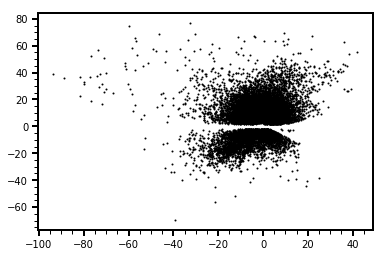

In [126]:
xpos,ypos,zpos = np.zeros(ra.size),np.zeros(ra.size),np.zeros(ra.size)

for indx in range(0,ra.size):
    xpos[indx],ypos[indx],zpos[indx] = rotate_positions(ra[indx]*np.pi/180.,dec[indx]*np.pi/180.,dist[indx])

plt.scatter(xpos,zpos,color='black',s=1.)

In [128]:
len(pmatch)

15852

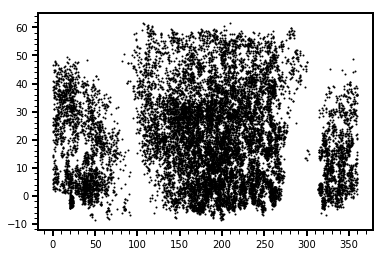

In [109]:
plt.scatter(ra,dec,color='black',s=1.)

In [222]:
ra.size

1

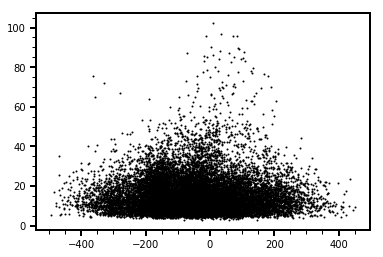

In [19]:
plt.scatter(rv,dist,color='black',s=1.)

In [22]:
f = open('data/LAMOST_K_MATCH.csv','w')

print('obsid,ra,dec,',file=f)

for indx in range(0,ra.size):
    print(obsid[indx],',',ra[indx],',',dec[indx],',',file=f)
    
f.close()

In [301]:
Gmatch["source_id"]

array([b'90198608955264', b'205780473330048', b'219219426355200', ...,
       b'6912668773929549056', b'6912692177207121024',
       b'6912944824363453568'], dtype='|S20')

In [69]:
Gmatch = np.genfromtxt('data/LAMOSTK-result.csv',\
                        dtype={'names': ("xsource_id","gsource_id","ra","ra_error","dec","dec_error",\
                                        "parallax","parallax_error","pmra","pmra_error","pmdec",\
                                         "pmdec_error","phot_g_mean_flux","phot_g_mean_flux_error","phot_g_mean_mag",\
                                         "phot_bp_mean_flux","phot_bp_mean_flux_error","bp_rp","radial_velocity","radial_velocity_error",\
                                         "phot_variable_flag","teff_val","a_g_val","pmcorr","dist","ruwe"),\
                             'formats': ('S20','S20','f8','f8','f8','f8',\
                                         'f8','f8','f8','f8','f8',\
                                         'f8','f8','f8','f8','f8',\
                                         'f8','f8','f8','f8','f8',\
                                        'f8','f8','f8','f8','f8','f8')},\
                 skip_header=1,delimiter=',')

In [300]:

# now with RUWE!
Gmatch = np.genfromtxt('data/LAMOSTK_RUWE-result.csv',\
                        dtype={'names': ("dec","parallax","dist","parallax_error",\
                                         "phot_bp_mean_flux_error","bp_rp","pmra","a_g_val","ra_error",\
                                         "pmra_error","pmdec_error","radial_velocity_error","pmra_pmdec_corr",\
                                         "teff_val","phot_g_mean_flux","phot_variable_flag","ra",\
                                         "phot_bp_mean_flux","phot_g_mean_flux_error","radial_velocity","xsource_id",\
                                         "dec_error","pmdec","phot_g_mean_mag","ruwe","source_id"),\
                             'formats': ('f8','f8','f8','f8',\
                                         'f8','f8','f8','f8','f8',\
                                         'f8','f8','f8','f8',\
                                         'f8','f8','f8','f8',\
                                         'f8','f8','f8','S20',\
                                         'f8','f8','f8','f8','S20')},\
                 skip_header=1,delimiter=',')

In [78]:
Gmatch['xsource_id'].astype('S20')
xsources = [int(d.decode()) for d in Gmatch['xsource_id']]

In [79]:
pmatch = []
for i in obsid:
    #print(i,xsources[0:10])
    w = np.where(xsources==i)[0]
    #print(w,w.size)
    if w.size>1:
        print(i,w,Gmatch['dist'][w],w[np.nanargmin(Gmatch['dist'][w])])
        pmatch.append(w[np.nanargmin(Gmatch['dist'][w])])
    else:
        pmatch.append(w[0])
    #print(w.size)

200112139 [10239 10240] [3.54274944e-05 2.68058543e-04] 10239
335805125 [6611 6612] [2.59652226e-04 1.52894763e-05] 6612
504807246 [3623 3624] [1.22683614e-04 8.44328963e-05] 3624
552506194 [14396 14397] [2.39406138e-04 1.29281390e-05] 14397
417201231 [9851 9852] [0.00018579 0.00026812] 9851
107208020 [2164 2165] [2.44855336e-04 5.14384207e-05] 2165
149001100 [7079 7080] [1.91820852e-05 2.11615787e-04] 7079
282104186 [352 353] [2.45264788e-04 5.71548124e-06] 353
241604122 [15301 15302] [2.2286219e-04 4.8134924e-05] 15302
215810103 [13765 13766] [2.72145941e-04 4.10919895e-05] 13766
284107178 [713 714] [2.59630512e-04 5.29612691e-06] 714
505202003 [9765 9766] [0.00010019 0.00020137] 9765
50609164 [15242 15243] [4.37407584e-05 2.63515829e-04] 15242
343913248 [6784 6785] [2.31426134e-04 2.62353957e-05] 6785
437415008 [3359 3360] [2.70457008e-04 6.21378576e-05] 3360
174512221 [3258 3259] [4.66052273e-05 2.14654999e-04] 3258
242202086 [15309 15310] [2.24395454e-04 3.72343329e-05] 15310
4481

54


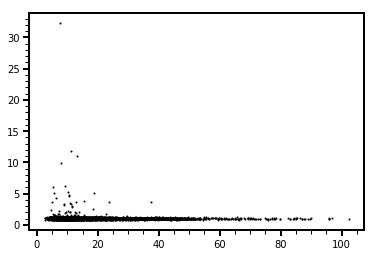

In [127]:
plt.scatter(dist,Gmatch['ruwe'][pmatch],color='black',s=1.)
bigruwe = np.where(Gmatch['ruwe'][pmatch]>=1.4)[0]
print(bigruwe.size)
goodruwe = np.where(Gmatch['ruwe'][pmatch]<1.4)[0]

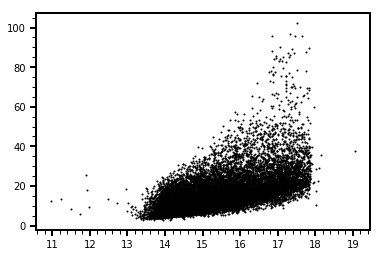

In [80]:
plt.scatter(Gmatch['phot_g_mean_mag'][pmatch],dist,color='black',s=1.)

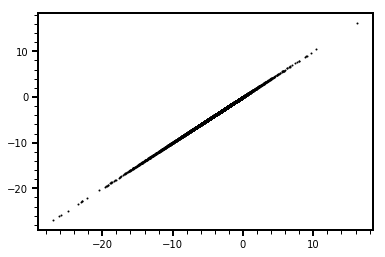

In [66]:
plt.scatter(pmdec,Gmatch['pmdec'][pmatch],color='black',s=1.)
# nice, we match perfectly.

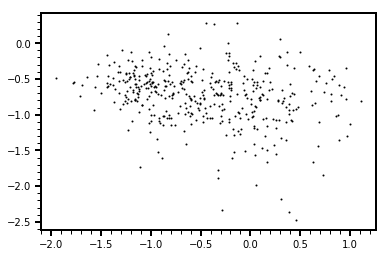

In [60]:
bigd = np.where(dist>40)

k = 4.74057
vra = Gmatch['pmra'][pmatch]

plt.scatter(Gmatch['pmra'][pmatch][bigd],Gmatch['pmdec'][pmatch][bigd],color='black',s=1.)

In [267]:
np.nanmedian(erv)

7.57

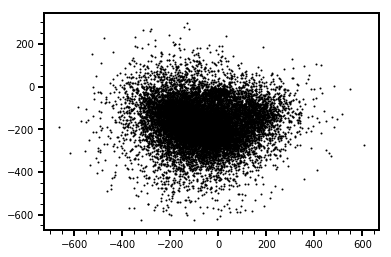

In [67]:
k = 4.74057
vra = Gmatch['pmra'][pmatch]*dist*k
vdec = Gmatch['pmdec'][pmatch]*dist*k

plt.scatter(vra,vdec,color='black',s=1.)


In [151]:
# set the coordinates for transformation

# use the schonrich 2010 peculiar motions
usun = 11.1
vsun = 12.24
wsun = 7.25

# use the circular velocity from ...
vcirc = 235.

# the value of mcmillan 2017
vcirc = 220.
#vcirc = 244.
#vcirc = 232.

# use the gravity 2018 result for the galactic center distance
rsun = 8.3 # in kpc

# use the sun's height above the midplane from Bovy...
zsun = 20 # in pc

v_sun = coord.CartesianDifferential([usun, vsun+vcirc, wsun]*u.km/u.s)
gc_frame = coord.Galactocentric(galcen_distance=rsun*u.kpc,
                                galcen_v_sun=v_sun,
                                z_sun=zsun*u.pc)


def find_errors(indx,nsamples=10000,verbose=False,sgr=False):
    rat = ra[indx]
    dect = dec[indx]
    dt = dist[indx]
    derrt = edist[indx]
    pmrat = Gmatch['pmra'][pmatch[indx]]
    pmraerrt = Gmatch['pmra_error'][pmatch[indx]]
    pmdect = Gmatch['pmdec'][pmatch[indx]]
    pmdecerrt = Gmatch['pmdec_error'][pmatch[indx]]
    vradt = rv[indx]
    vraderrt = erv[indx]
    
    print(rat,dect,dt)

    cplus = coord.SkyCoord(ra              = np.tile(rat,nsamples)                                 * u.deg,\
                           dec             = np.tile(dect,nsamples)                                 * u.deg,\
                           distance        = np.nanmax([np.zeros(nsamples)+.1,(dt     + np.random.normal(size=nsamples)*derrt)],axis=0)     * u.kpc,\
                           pm_ra_cosdec    = (pmrat  + np.random.normal(size=nsamples)*pmraerrt)  * u.mas/u.yr,\
                           pm_dec          = (pmdect + np.random.normal(size=nsamples)*pmdecerrt) * u.mas/u.yr,\
                           radial_velocity = (vradt  + np.random.normal(size=nsamples)*vraderrt)  * u.km/u.s)

    cbest = coord.SkyCoord(ra              = rat    * u.deg,\
                           dec             = dect   * u.deg,\
                           distance        = dt     * u.kpc,\
                           pm_ra_cosdec    = pmrat  * u.mas/u.yr,\
                           pm_dec          = pmdect * u.mas/u.yr,\
                           radial_velocity = vradt  * u.km/u.s)

    if verbose:
        print(pmrat,pmdect,vradt)

    gal_latlon  = cplus.transform_to('galactic')
    gal_defined = cplus.transform_to(gc_frame)
        
    best_latlon  = cbest.transform_to('galactic')
    best_defined = cbest.transform_to(gc_frame)
    
    if sgr:
        best_sgr = cbest.transform_to(Sagittarius)
        return gal_latlon,gal_defined,best_latlon,best_defined,best_sgr
    
    else:
        return gal_latlon,gal_defined,best_latlon,best_defined


indx = 0
gal_latlon,gal_defined,best_latlon,best_defined = find_errors(indx,nsamples=1000,verbose=False)

gal_latlon,gal_defined,best_latlon,best_defined,best_sgr = find_errors(indx,nsamples=1000,verbose=True,sgr=True)


print(best_defined)

print(best_latlon)
print(best_sgr)


169.695884 5.530107 11.8777
169.695884 5.530107 11.8777
-1.736054731500345 -2.3774431462917933 294.41
<SkyCoord (Galactocentric: galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    (266.4051, -28.936175)>, galcen_distance=8.3 kpc, galcen_v_sun=(11.1, 232.24, 7.25) km / s, z_sun=20.0 pc, roll=0.0 deg): (x, y, z) in kpc
    (-10.03800633, -5.83303029, 10.21974339)
 (v_x, v_y, v_z) in km / s
    (-53.99694642, -53.30984762, 175.70053925)>
<SkyCoord (Galactic): (l, b, distance) in (deg, deg, kpc)
    (253.18657516, 59.13476612, 11.8777)
 (pm_l_cosb, pm_b, radial_velocity) in (mas / yr, mas / yr, km / s)
    (0.35333654, -2.92254602, 294.41)>
<SkyCoord (Sagittarius): (Lambda, Beta, distance) in (deg, deg, kpc)
    (245.11060567, 15.50593306, 11.8777)
 (pm_Lambda_cosBeta, pm_Beta, radial_velocity) in (mas / yr, mas / yr, km / s)
    (-0.70565029, 2.85800273, 294.41)>


In [137]:
indx = 0
rotate_velocities(ra[indx]*np.pi/180.,dec[indx]*np.pi/180.,Gmatch['pmra'][pmatch[indx]],Gmatch['pmdec'][pmatch[indx]])

(0.3533368461116067, -2.9225459821522843)

In [279]:
cbest = coord.SkyCoord(ra              = ra    * u.deg,\
                       dec             = dec   * u.deg,\
                       distance        = dist  * u.kpc,\
                       pm_ra_cosdec    = Gmatch['pmra'][pmatch]  * u.mas/u.yr,\
                       pm_dec          = Gmatch['pmdec'][pmatch] * u.mas/u.yr,\
                       radial_velocity = rv  * u.km/u.s)

In [280]:
best_defined = cbest.transform_to(gc_frame)
best_sgr     = cbest.transform_to(Sagittarius)
best_latlon  = cbest.transform_to('galactic')

np.array(best_sgr.Beta)


array([ 15.50593306,  18.34484126, -40.32507924, ...,   7.09248352,
       -29.04131046, -42.12022334])

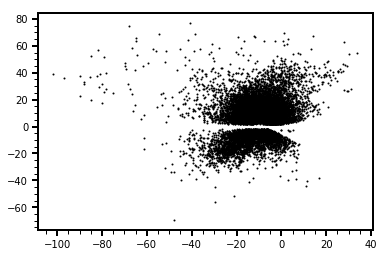

In [281]:
plt.scatter(best_defined.x,best_defined.z,color='black',s=1.)

In [147]:
# back out the rotated correlation coefficients
pm_l_err = np.zeros(len(pmatch))
pm_b_err = np.zeros(len(pmatch))
corrcoef = np.zeros(len(pmatch))
pm_l     = np.zeros(len(pmatch))
pm_b     = np.zeros(len(pmatch))

for i in range(0,len(pmatch)):
    #print(i)
    e1 = Gmatch['pmra_error'][pmatch][i]
    e2 = Gmatch['pmdec_error'][pmatch][i]
    e3 = Gmatch['pmra_pmdec_corr'][pmatch][i]
    cov_to = rotate_errors(Gmatch['ra'][pmatch][i]*np.pi/180.,Gmatch['dec'][pmatch][i]*np.pi/180.,\
                       e1,e2,e3)
    
    corrcoef[i] = cov_to[0][1]/(np.sqrt(cov_to[0][0])*np.sqrt(cov_to[1][1]))
    pm_l_err[i] = np.sqrt(cov_to[0][0])
    pm_b_err[i] = np.sqrt(cov_to[1][1])
    
    lbvel = rotate_velocities(Gmatch['ra'][pmatch][i]*np.pi/180.,Gmatch['dec'][pmatch][i]*np.pi/180.,\
                              Gmatch['pmra'][pmatch][i],Gmatch['pmdec'][pmatch][i])
    
    pm_l[i] = lbvel[0]
    pm_b[i] = lbvel[1]






In [154]:
corrcoef.size

15852

In [149]:
pm_l[0],pm_b[0]

(0.35333797538046857, -2.9225458456230564)

In [217]:
np.array(best_latlon.pm_b[100]),pm_b[100]

(array(-1.74411709), -1.7441207860137264)

In [160]:

f = open('/Users/mpetersen/Dropbox/mike/data/LAMOST_K_FULL.txt','w')

print("x [kpc]; y [kpc]; z [kpc]; vx [km/s]; vy [km/s]; vz [km/s];      l [deg]; b [deg]; dist [kpc]; vlos [km/s]; dmu_l [marcsec/yr]; dmu_b [marcsec/yr];       edist[kpc]; evlost [km/s]; edmu_l [marcsec/yr]; edmu_b [marcsec/yr];      sgrweak [bool]; sgrstrong [bool]; FeH [dex]; Sgr Lambda [deg]; Sgr Beta [deg]; Belokurov Flag [bool]; corrcoef [-1:1]",file=f)

rej = 0
for i in range(0,len(pmatch)):
    if Gmatch['ruwe'][pmatch][i] < 1.4:
        print(np.array(best_defined.x)[i],np.array(best_defined.y)[i],np.array(best_defined.z)[i],\
              np.array(best_defined.v_x)[i],np.array(best_defined.v_y)[i],np.array(best_defined.v_z)[i],\
              np.array(best_latlon.l)[i],np.array(best_latlon.b)[i],dist[i],\
              rv[i],pm_l[i],pm_b[i],\
              edist[i],erv[i],pm_l_err[i],pm_b_err[i],\
              0,0,0,\
              np.array(best_sgr.Lambda)[i],np.array(best_sgr.Beta)[i],0,\
              corrcoef[i],file=f)
    else:
        rej +=1
        print('REJECTED!')
    
          
f.close()
print(rej)


REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
54


In [303]:

#f = open('/Users/mpetersen/Dropbox/mike/data/LAMOST_K_FULL_overlap.txt','w')
f = open('/Users/mpetersen/Downloads/LAMOST_K_FULL_overlap.txt','w')


print("x [kpc]; y [kpc]; z [kpc]; vx [km/s]; vy [km/s]; vz [km/s];      l [deg]; b [deg]; dist [kpc]; vlos [km/s]; dmu_l [marcsec/yr]; dmu_b [marcsec/yr];       edist[kpc]; evlost [km/s]; edmu_l [marcsec/yr]; edmu_b [marcsec/yr];      sgrweak [bool]; sgrstrong [bool]; FeH [dex]; Sgr Lambda [deg]; Sgr Beta [deg]; Belokurov Flag [bool]; corrcoef [-1:1];GaiaO",file=f)

rej = 0
for i in range(0,len(pmatch)):
    if Gmatch['ruwe'][pmatch][i] < 1.4:
        if i in oflag:
            print(np.array(best_defined.x)[i],np.array(best_defined.y)[i],np.array(best_defined.z)[i],\
              np.array(best_defined.v_x)[i],np.array(best_defined.v_y)[i],np.array(best_defined.v_z)[i],\
              np.array(best_latlon.l)[i],np.array(best_latlon.b)[i],dist[i],\
              rv[i],pm_l[i],pm_b[i],\
              edist[i],erv[i],pm_l_err[i],pm_b_err[i],\
              0,0,0,\
              np.array(best_sgr.Lambda)[i],np.array(best_sgr.Beta)[i],0,\
              corrcoef[i],Gmatch["source_id"][pmatch][i].decode(),file=f)
    else:
        rej +=1
        print('REJECTED!')
    
          
f.close()
print(rej)



REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
REJECTED!
54


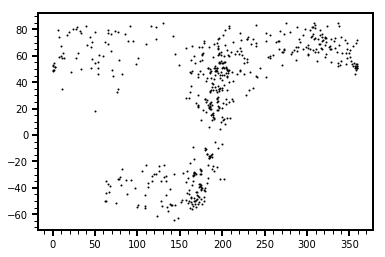

In [286]:
LK = np.genfromtxt('/Users/mpetersen/Dropbox/mike/data/LAMOST_K_FULL.txt',skip_header=1)

#LK = np.genfromtxt('/Users/mpetersen/Downloads/LAMOST_K_FULL_overlap.txt',skip_header=1)

rgal = np.sqrt(LK[:,0]*LK[:,0] + LK[:,1]*LK[:,1] + LK[:,2]*LK[:,2])
l = LK[:,6]
b = LK[:,7]
sgrb = LK[:,20]
coef = LK[:,22]
pml = LK[:,10]
pmb = LK[:,11]
vlos = LK[:,9]
#plt.scatter(l[np.abs(sgrb)<20],b[np.abs(sgrb)<20],color='grey',s=.1)
plt.scatter(l[rgal>40],b[rgal>40],color='black',s=1.)


#plt.plot(rgal[rgal.argsort()])

In [187]:
print(np.where(rgal>40)[0].size)

544


In [215]:
l.size

15798

In [194]:
In = np.genfromtxt('processed/KGiants_cartesian_heliocentric_sgr.txt',skip_header=1)

sdssl    = In[:,6]
sdssb    = In[:,7]
sdssd    = In[:,8]
sdssvr   = In[:,9]
sdssdml  = In[:,10]
sdssdmb  = In[:,11]


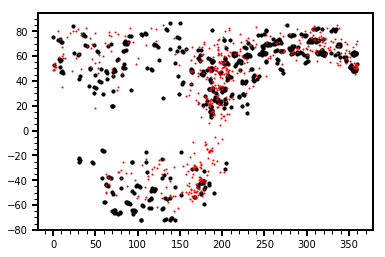

In [289]:
plt.scatter(sdssl[sdssd>40],sdssb[sdssd>40],color='black',s=10.)

plt.scatter(l[rgal>40],b[rgal>40],color='red',s=1.)



In [213]:
overlap = 0

for indx in range(0,l.size):
    w = np.where((np.abs(sdssl-l[indx])<0.01) & (np.abs(sdssb-b[indx])<0.01))[0]
    #w = np.nanargmin(np.abs(sdssl-l))
    #if np.abs(b[indx]-sdssb[w]) < 0.1:
    if len(w)>0:
        overlap+=1
        print(l[indx],sdssl[w[0]],b[indx],sdssb[w[0]],sdssdml[w[0]],pml[w[0]],)
    #if GmatchS['dec'][indx]
    
print(overlap)

171.154574375916 171.15 -52.14497095300951 -52.15 1.0255 6.416975295876596
247.79977547818547 247.79 53.30220135558876 53.31 0.5469 -7.080179679648418
31.58452726169597 31.59 42.81830598471339 42.81 -8.6743 -2.7076543513250124
3


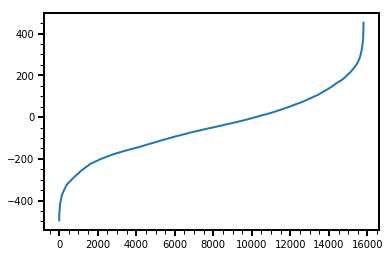

In [185]:
plt.plot(vlos[vlos.argsort()])

In [188]:
GmatchS = np.genfromtxt('data/Xue2015KGiantxmatch_gaia_corr.txt',\
                        dtype={'names': ("xsource_id","gsource_id","ra","ra_error","dec","dec_error",\
                                        "parallax","parallax_error","pmra","pmra_error","pmdec",\
                                         "pmdec_error","phot_g_mean_flux","phot_g_mean_flux_error","phot_g_mean_mag",\
                                         "phot_bp_mean_flux","phot_bp_mean_flux_error","bp_rp","radial_velocity","radial_velocity_error",\
                                         "phot_variable_flag","teff_val","a_g_val","pmcorr","dist"),\
                             'formats': ('S20','S20','f8','f8','f8','f8',\
                                         'f8','f8','f8','f8','f8',\
                                         'f8','f8','f8','f8','f8',\
                                         'f8','f8','f8','f8','f8',\
                                        'f8','f8','f8','f8','f8')},\
                 skip_header=1,delimiter=',')



In [200]:
GmatchS['ra'].size,sdssl.size

(6040, 6016)

In [214]:
overlap = 0

for indx,ra in enumerate(GmatchS['ra']):
    w = np.nanargmin(np.abs(Gmatch['ra']-ra))
    if np.abs(GmatchS['dec'][indx]-Gmatch['dec'][w]) < 0.01:
        overlap+=1
        print(ra,Gmatch['ra'][w],GmatchS['dec'][indx],Gmatch['dec'][w])
    #if GmatchS['dec'][indx]
    
print(overlap)

220.11678711614755 220.11678711614755 1.0311592539675414 1.0311592539675414
186.99638883753073 186.99638883753073 1.8225764219871485 1.8225764219871485
196.8281503876896 196.8281503876896 3.2369481991875415 3.2369481991875415
198.8115950705276 198.8115950705276 3.115516154816383 3.115516154816383
201.36253344502722 201.36253344502722 2.1578000055145146 2.1578000055145146
200.95014236926193 200.95014236926193 2.377714353589522 2.377714353589522
206.84850129399578 206.84850129399578 1.5948611079700241 1.5948611079700241
222.61128253007988 222.61128253007988 4.132961989183567 4.132961989183567
223.53573978520822 223.53573978520822 4.686787197523909 4.686787197523909
212.53108302972305 212.53108302972305 51.58713525209367 51.58713525209367
23.471913250345015 23.471913250345015 -0.6803618791298923 -0.6803618791298923
21.452600924987156 21.452600924987156 -0.6200742992752676 -0.6200742992752676
325.91008419779365 325.91008419779365 -1.2221167148112402 -1.2221167148112402
335.74149179075255 3

348.3279185976081 348.3279185976081 23.00694105144959 23.00694105144959
111.61020628255585 111.61020628255585 30.800048591988578 30.800048591988578
102.1363865096813 102.1363865096813 36.79807007080101 36.79807007080101
113.6370984748532 113.6370984748532 40.370216403477514 40.370216403477514
112.10496813206855 112.10496813206855 40.8030197982279 40.8030197982279
113.46284334356034 113.46284334356034 14.994920692182555 14.994920692182555
119.42475352817802 119.42475352817802 18.648645239797478 18.648645239797478
251.9665424032768 251.9665424032768 13.350083776668944 13.350083776668944
252.77695384761884 252.77695384761884 12.599303060926497 12.599303060926497
0.8453524488556248 0.8453524488556248 25.672214201517303 25.672214201517303
359.45619942725614 359.45619942725614 28.429075880234176 28.429075880234176
17.175859624027474 17.175859624027474 14.826862115558662 14.826862115558662
256.9664449049022 256.9664449049022 28.116580285789393 28.116580285789393
313.71601525061635 313.7160152

194.04662118148389 194.04662118148389 10.795471147638686 10.795471147638686
194.59539083708515 194.59539083708515 9.987528643068524 9.987528643068524
19.481524524202328 19.481524524202328 6.193899178628185 6.193899178628185
19.672100608054606 19.672100608054606 7.011664722666697 7.011664722666697
19.054561877868405 19.054561877868405 6.293278751020391 6.293278751020391
18.16187603139135 18.16187603139135 7.312182464623081 7.312182464623081
17.84469667759799 17.84469667759799 7.67749508839126 7.67749508839126
19.07810116613637 19.07810116613637 7.746099605126615 7.746099605126615
19.65330531709353 19.65330531709353 8.032081574204112 8.032081574204112
12.58475876827803 12.58475876827803 1.155995241233062 1.155995241233062
31.0038761670221 31.0038761670221 6.596179048135719 6.596179048135719
30.099423623968253 30.099423623968253 5.811443849690457 5.811443849690457
30.67456393651251 30.67456393651251 7.538274128198441 7.538274128198441
30.61583980709187 30.61583980709187 6.991654864161195 

179.43030081853988 179.43030081853988 6.785737087832334 6.785737087832334
151.365718850633 151.365718850633 13.581883826806239 13.581883826806239
150.058915832133 150.058915832133 12.85889512613746 12.85889512613746
149.2154696106144 149.2154696106144 13.506503814171825 13.506503814171825
149.52513384862448 149.52513384862448 14.761119079296066 14.761119079296066
150.07185404897604 150.07185404897604 14.66339205466762 14.66339205466762
149.92921725167608 149.92921725167608 14.100181300287744 14.100181300287744
150.8779784194078 150.8779784194078 14.730349820068023 14.730349820068023
153.12240278841617 153.12240278841617 12.72761889053964 12.72761889053964
151.39225186079662 151.39225186079662 12.510206787620728 12.510206787620728
152.2879985192539 152.2879985192539 14.587778745815221 14.587778745815221
153.474426190789 153.474426190789 13.324751936788099 13.324751936788099
158.8054923877354 158.8054923877354 22.565116735159982 22.565116735159982
159.59003028568614 159.59003028568614 25

215.45301362317323 215.45301362317323 28.976039762199527 28.976039762199527
217.35941644041134 217.35941644041134 28.8852362773185 28.8852362773185
218.16745324918875 218.16745324918875 28.442730691538866 28.442730691538866
222.45398168113266 222.45398168113266 42.25442493130633 42.25442493130633
224.39948668253686 224.39948668253686 41.47741242521676 41.47741242521676
223.18379568829138 223.18379568829138 12.57072786080001 12.57072786080001
251.24484641643932 251.24484641643932 40.77035404989151 40.77035404989151
252.63273796622903 252.63273796622903 39.67000599372521 39.67000599372521
242.5251412928665 242.5251412928665 46.18356193944457 46.18356193944457
242.1377474757852 242.1377474757852 45.443831824608814 45.443831824608814
242.29142674485612 242.29142674485612 45.42747563659973 45.42747563659973
230.72666104141868 230.72666104141868 51.535991914066464 51.535991914066464
231.71689934876662 231.71689934876662 53.38325461412756 53.38325461412756
231.0676872037751 231.0676872037751 

In [220]:



X14 = np.genfromtxt('data/Xue2014KGiant14.txt',\
                        dtype={'names': ("RA","Dec","rmag","ermag",\
                                         "gr","egr","HRV","eHRV",\
                                         "Teff","FeH","eFeH","logg",\
                                         "DMpeak","DM05","DM16","DM50",\
                                         "DM85","DM95","DMerror","rMag","erMag",\
                                         "d","ed","rGC","erGC",\
                                         "Pabove"),\
                             'formats': ('f8','f8','f8','f8',\
                                        'f8','f8','f8','f8',\
                                        'f8','f8','f8','f8',\
                                         'f8','f8','f8','f8',\
                                         'f8','f8','f8','f8','f8',\
                                        'f8','f8','f8','f8',\
                                        'f8')},\
                 skip_header=47)





In [274]:
np.nanmedian(X14['ed']/X14['d'])

0.15563569095949248

599


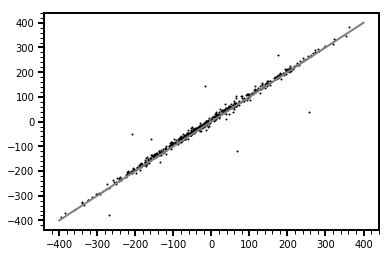

In [271]:
overlap = 0
oflag = []
rv1 = []
rv2 = []
erv1 = []
erv2 = []
d1 = []
d2 = []
m2 = []

for indx in range(0,ra.size):
    w = np.nanargmin(np.abs(X14['RA']-ra[indx]))
    if np.abs(dec[indx]-X14['Dec'][w]) < 0.01:
        oflag.append(indx)
        overlap+=1
        #print(ra[indx],X14['RA'][w],dec[indx],X14['Dec'][w])
        #plt.scatter(dist[indx],X14['d'][w],color='black',s=1.)
        plt.scatter(rv[indx],X14['HRV'][w],color='black',s=1.)
        rv1.append(rv[indx])
        rv2.append(X14['HRV'][w])
        erv1.append(erv[indx])
        erv2.append(X14['eHRV'][w])
        d1.append(dist[indx])
        d2.append(X14['d'][w])
        m2.append(X14['FeH'][w])
        #plt.scatter(rv[indx],np.abs(X14['HRV'][w]-rv[indx])/X14['eHRV'][w],color='black',s=1.)
        #plt.scatter(rv[indx],np.abs(X14['HRV'][w]-rv[indx])/erv[indx],color='red',s=4.)


    #if GmatchS['dec'][indx]
    
print(overlap)
plt.plot([-400,400],[-400,400],color='grey')
#plt.ylim(0.,10.)

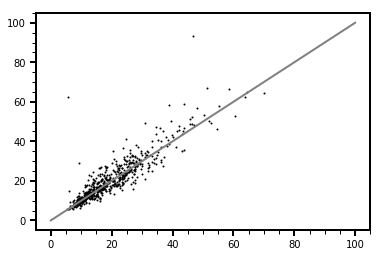

In [270]:
plt.scatter(np.array(d1),np.array(d2),color='black',s=1.)
plt.plot([0.,100.],[0.,100],color='grey')

In [278]:
print(np.where( (np.array(d1)>40) & (np.array(d2)>40))[0].size)

26


In [248]:
print(np.nanmedian(np.array(rv1)-np.array(rv2)))

-7.890000000000001


(0.0, 5.0)

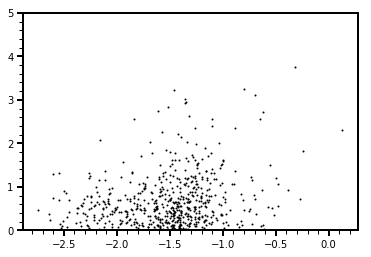

In [272]:
plt.scatter(np.array(m2),np.abs(np.array(rv1)-np.array(rv2)+8.)/np.array(erv1),color='black',s=1.)

plt.ylim(0.,5.)


In [257]:
print(np.nanmean(np.array(erv2)))

1.605008347245409


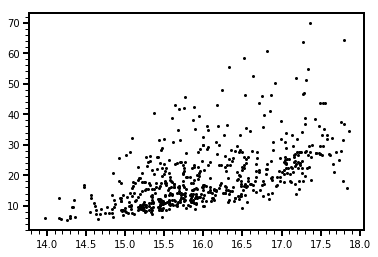

In [238]:
plt.scatter(Gmatch['phot_g_mean_mag'][pmatch][oflag],dist[oflag],color='black',s=4.)

In [320]:

OLK = np.genfromtxt('/Users/mpetersen/Downloads/LAMOST_K_FULL_overlap.txt',dtype=None,skip_header=1)
#OLK[:,22]
print(OLK.size)

OLKnum = []
for i in range(OLK.size):
    OLKnum.append(OLK[i][23])
    
#print(OLKnum)
OLK = np.genfromtxt('/Users/mpetersen/Downloads/LAMOST_K_FULL_overlap.txt',skip_header=1)



598


In [321]:
SK = np.genfromtxt('/Users/mpetersen/Downloads/KGiants_cartesian_heliocentric_sgr.txt',dtype=None,skip_header=1)

SKnum = []
for i in range(SK.size):
    SKnum.append(SK[i][23])
    
SK = np.genfromtxt('/Users/mpetersen/Downloads/KGiants_cartesian_heliocentric_sgr.txt',skip_header=1)





590


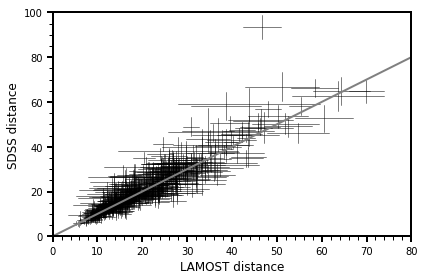

In [341]:
olap = 0
for i,o in enumerate(OLKnum):
    w = np.where(np.array(SKnum)==o)[0]
    if len(w)>0:
        #print(o,np.array(SKnum)[w[0]])
        #print(OLK[i,10],SK[w[0],10])
        plt.plot([OLK[i,8]-OLK[i,12],OLK[i,8]+OLK[i,12]],[SK[w[0],8],SK[w[0],8]],color='black',lw=0.5)
        plt.plot([OLK[i,8],OLK[i,8]],[SK[w[0],8]-SK[w[0],12],SK[w[0],8]+SK[w[0],12]],color='black',lw=0.5)
        olap += 1
        
print(olap)
plt.plot([0,100],[0,100],color='grey')
plt.axis([0.,80.,0.,100.])
plt.xlabel('LAMOST distance',size=12)
plt.ylabel('SDSS distance',size=12)
plt.tight_layout()
plt.savefig('/Users/mpetersen/Downloads/lamost-sdss.png')

590 54


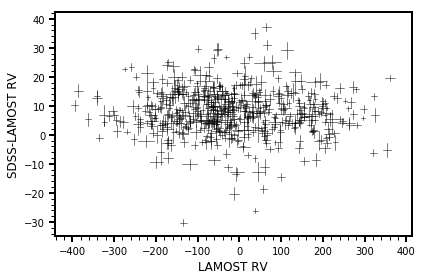

In [346]:
olap = 0
ldist = 0
for i,o in enumerate(OLKnum):
    w = np.where(np.array(SKnum)==o)[0]
    if len(w)>0:
        #print(o,np.array(SKnum)[w[0]])
        #print(OLK[i,10],SK[w[0],10])
        #plt.plot([OLK[i,9]-OLK[i,13],OLK[i,9]+OLK[i,13]],[SK[w[0],9],SK[w[0],9]],color='black',lw=0.5)
        #plt.plot([OLK[i,9],OLK[i,9]],[SK[w[0],9]-SK[w[0],13],SK[w[0],9]+SK[w[0],13]],color='black',lw=0.5)
        plt.plot([OLK[i,9]-OLK[i,13],OLK[i,9]+OLK[i,13]],[SK[w[0],9]-OLK[i,9],SK[w[0],9]-OLK[i,9]],color='black',lw=0.5)
        plt.plot([OLK[i,9],OLK[i,9]],[SK[w[0],9]-SK[w[0],13]-OLK[i,9],SK[w[0],9]+SK[w[0],13]-OLK[i,9]],color='black',lw=0.5)
        olap += 1
        if SK[i,8]>40:
            ldist += 1
        
print(olap,ldist)
#plt.plot([-400,400],[-400,400],color='grey')
#plt.axis([0.,80.,0.,100.])
plt.xlabel('LAMOST RV',size=12)
plt.ylabel('SDSS-LAMOST RV',size=12)
plt.tight_layout()
plt.savefig('/Users/mpetersen/Downloads/lamost-sdss-vlos.png')